In [1]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_FEB_2023, token_lease_fee=0.20)
epochs = 3 * YEAR + 1
stats_interval = DAY

In [2]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [3]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,1,312261302288384,1000.0000,1000.0002,1000.0000,0.0000,-0.0002,0.0000,0.0000,0.0002,1978.9123,978.9123,49.47
1,1,2881,312261302288384,1002.8394,1000.5470,1002.8394,0.0000,2.2924,3.7859,0.9452,0.5483,1978.9123,976.0729,49.32
2,2,5761,312261302288384,1005.6779,1001.0917,1005.6779,0.0000,4.5862,7.5706,1.8877,1.0967,1978.9123,973.2344,49.18
3,3,8641,312261302288384,1008.5155,1001.6342,1008.5155,0.0000,6.8813,11.3541,2.8275,1.6454,1978.9123,970.3968,49.04
4,4,11521,312261302288384,1011.3522,1002.1746,1011.3522,0.0000,9.1776,15.1365,3.7645,2.1944,1978.9123,967.5601,48.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,312261302288384,3007.2777,0.0000,1978.9123,1028.3654,3007.2777,3493.3105,169.4321,316.6007,1978.9123,0.0000,0.00
1092,1092,3144961,312261302288384,3009.9582,0.0000,1978.9123,1031.0458,3009.9582,3495.9910,169.4321,316.6007,1978.9123,0.0000,0.00
1093,1093,3147841,312261302288384,3012.6378,0.0000,1978.9123,1033.7254,3012.6378,3498.6706,169.4321,316.6007,1978.9123,0.0000,0.00
1094,1094,3150721,312261302288384,3015.3165,0.0000,1978.9123,1036.4042,3015.3165,3501.3493,169.4321,316.6007,1978.9123,0.0000,0.00


<Figure size 640x480 with 0 Axes>

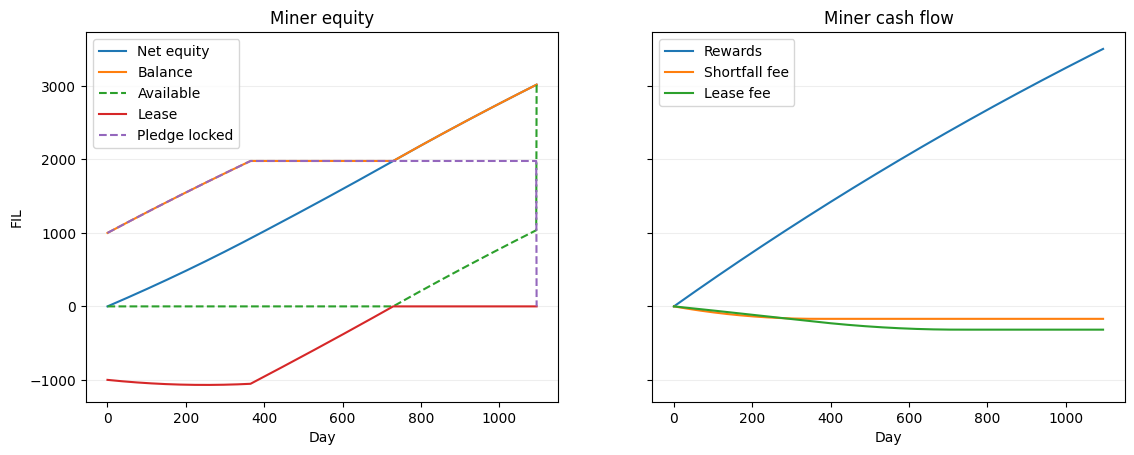

In [4]:
show_miner_accounting_charts(repay_shortfall_df)

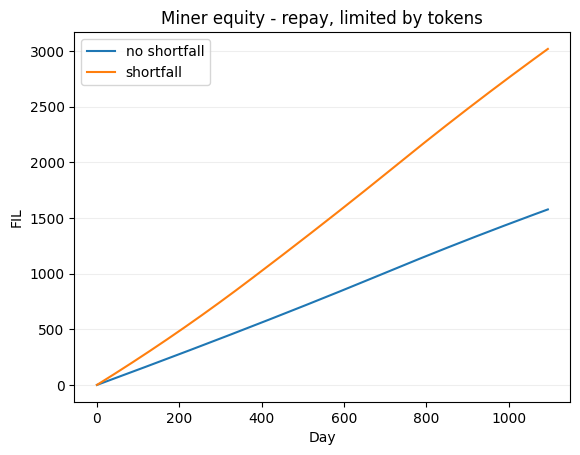

In [5]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}, 'repay, limited by tokens')

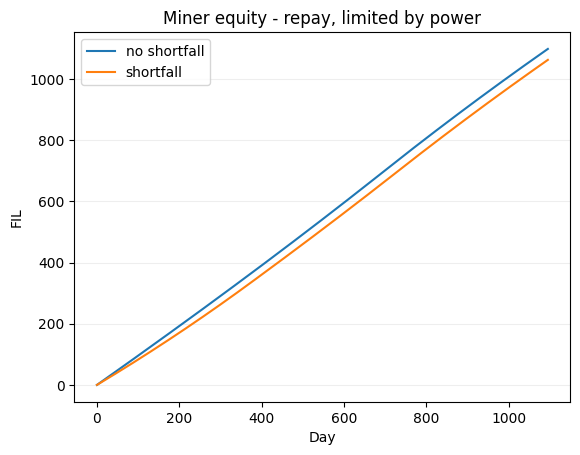

In [6]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, False),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, True),
        miner_factory=RepayRatchetShortfallMinerState.factory(balance=0),
    )
}, 'repay, limited by power')

## Burn the shortfall

In [7]:
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=BurnShortfallMinerState.factory(balance=0),
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,0,1,315559837171712,1000.0000,1000.0002,1000.0,0.0000,-0.0002,0.0000,0.0000,0.0002,999.8163
1,1,2881,315559837171712,1000.0000,999.5900,1000.0,0.0000,0.4100,3.8259,2.8679,0.5480,996.9485
2,2,5761,315559837171712,1000.0000,999.1771,1000.0,0.0000,0.8229,7.6506,5.7321,1.0956,994.0842
3,3,8641,315559837171712,1000.0000,998.7616,1000.0,0.0000,1.2384,11.4741,8.5927,1.6430,991.2237
4,4,11521,315559837171712,1000.0000,998.3433,1000.0,0.0000,1.6567,15.2964,11.4495,2.1902,988.3668
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,315559837171712,2319.5086,0.0000,1000.0,1319.5086,2319.5086,3530.2117,995.6164,215.0867,4.1999
1092,1092,3144961,315559837171712,2322.1948,0.0000,1000.0,1322.1948,2322.1948,3532.9205,995.6390,215.0867,4.1774
1093,1093,3147841,315559837171712,2324.8803,0.0000,1000.0,1324.8803,2324.8803,3535.6284,995.6614,215.0867,4.1550
1094,1094,3150721,315559837171712,2327.5650,0.0000,1000.0,1327.5650,2327.5650,3538.3354,995.6837,215.0867,4.1327


<Figure size 640x480 with 0 Axes>

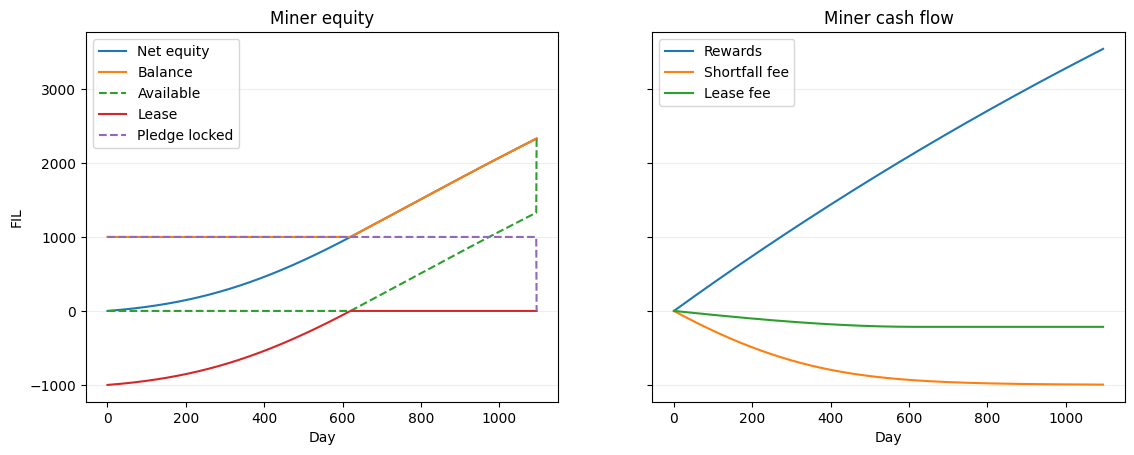

In [8]:
show_miner_accounting_charts(burn_shortfall_df)

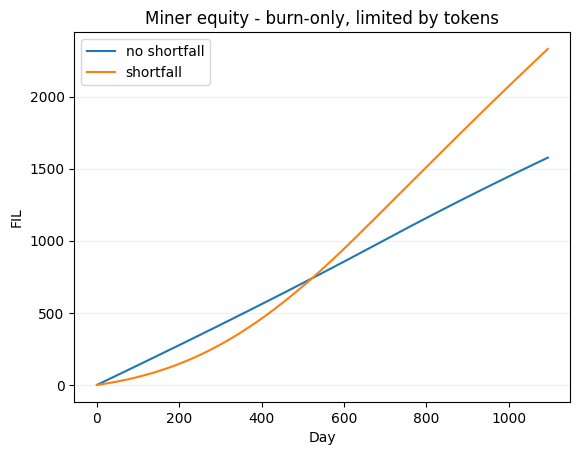

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    )
}, 'burn-only, limited by tokens')


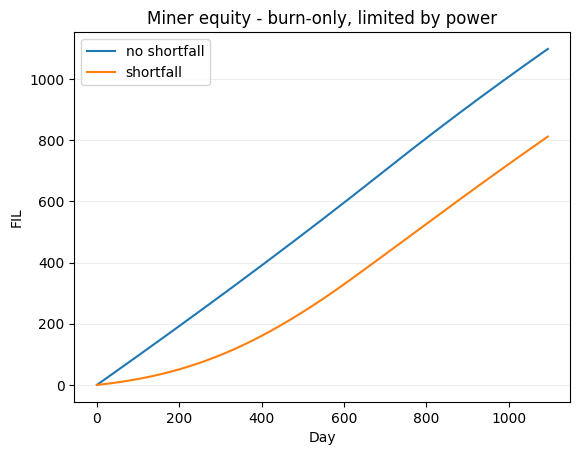

In [10]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, False),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, True),
        miner_factory=BurnShortfallMinerState.factory(balance=0),
    )
}, 'burn-only, limited by power')
